<a href="https://colab.research.google.com/github/UoR-Vision/VisualDota/blob/main/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

## Install Required Packages

In [ ]:
!pip install importlib ultralytics torch torchvision shapely

***
<a id="import"></a>
## Import libraries

To import the required libraries for whole project.

In [2]:
# import the build-in required libraries
from collections import Counter, defaultdict
import os
import time
import warnings

# import the third-part required libraries
import cv2
import importlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
import ultralytics
from zipfile import ZipFile


# check the versions of third-part libraries
print(f'matplotlib: {matplotlib.__version__}, numpy: {np.__version__}, pandas: {pd.__version__}')
print(f'torch: {torch.__version__}, torchvision: {torchvision.__version__}, ultralytics: {ultralytics.__version__}')

# check environment
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

WARNING  Ultralytics setting 'datasets_dir: ' must be different than 'runs_dir: '. Please change one to avoid possible issues during training. 
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\weiji\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
matplotlib: 3.9.0, numpy: 2.1.1, pandas: 2.2.3
torch: 2.6.0+cpu, torchvision: 0.21.0+cpu, ultralytics: 8.3.105
device: cpu


***
<a id="colab"></a>
## Adapting to the Colab Operating Environment

In Colab environment, it is neccessary to download the whole project from Github.

In [3]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False


if is_colab():
    print('Running in Google Colab!')
    !git clone "https://github.com/UoR-Vision/VisualDota.git" -b main
    %cd VisualDota/src
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        DATASET_ROOT_DIR = '/content/drive/MyDrive/VisualDota/DOTA'
        MODEL_ROOT_DIR = '/content/drive/MyDrive/VisualDota/models'
    except ImportError as e:
        print(f'failed to import google package: {e.msg}')
        DATASET_ROOT_DIR = './data'
        MODEL_ROOT_DIR = '../models'

else:
    print('Not running in Colab.')
    DATASET_ROOT_DIR = './data'
    MODEL_ROOT_DIR = '../models'

Not running in Colab.


***
<a id="hotload"></a>
## Hot Loading .py File

Here is to import custom .py file. It can be hot-loaded, just re-run the following cell.

Documentation comments are provided for each public function. To check the comments please use the help() function.

In [4]:
try:
    import data_loader  # import data loader for data training
    import data_process  # import data_process for data pre-processing
    import modeling_faster_rcnn  # import faster-rcnn model
    import modeling_yolo11  # import yolo-v11 model
    import visual_utils  # import visual utils for visualization
    import data_validation  # import data_validation for validation
except ModuleNotFoundError as e:
    print(f'[ERROR] fail to import a custom module at path: {os.path.abspath(".")}, msg: {e}.')
except Exception as e:
    print(f'[ERROR] fail to read module at path: {os.path.abspath(".")}, msg: {e}')
else:
    # Hot loading python files
    importlib.reload(data_loader)
    importlib.reload(data_process)
    importlib.reload(modeling_faster_rcnn)
    importlib.reload(modeling_yolo11)
    importlib.reload(visual_utils)
    importlib.reload(data_validation)

# 2 Exploratory data analysis

## 2.1 Object Category Distribution

In [5]:
zip_path = os.path.abspath("./data/labelTxt.zip")

category_counts = Counter()

with ZipFile(zip_path, 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.txt'):
            with zip_file.open(file_name) as file:
                for line in file:
                    try:
                        parts = line.decode('utf-8').strip().split()
                        if len(parts) >= 10:
                            category = parts[8].strip()
                            category_counts[category] += 1
                    except Exception as e:
                        print(f"[ERROR] {file_name}: {e}")

# Convert to DataFrame
df_counts = pd.DataFrame(category_counts.items(), columns=["Category", "Count"])
df_counts = df_counts.sort_values(by="Count", ascending=False)

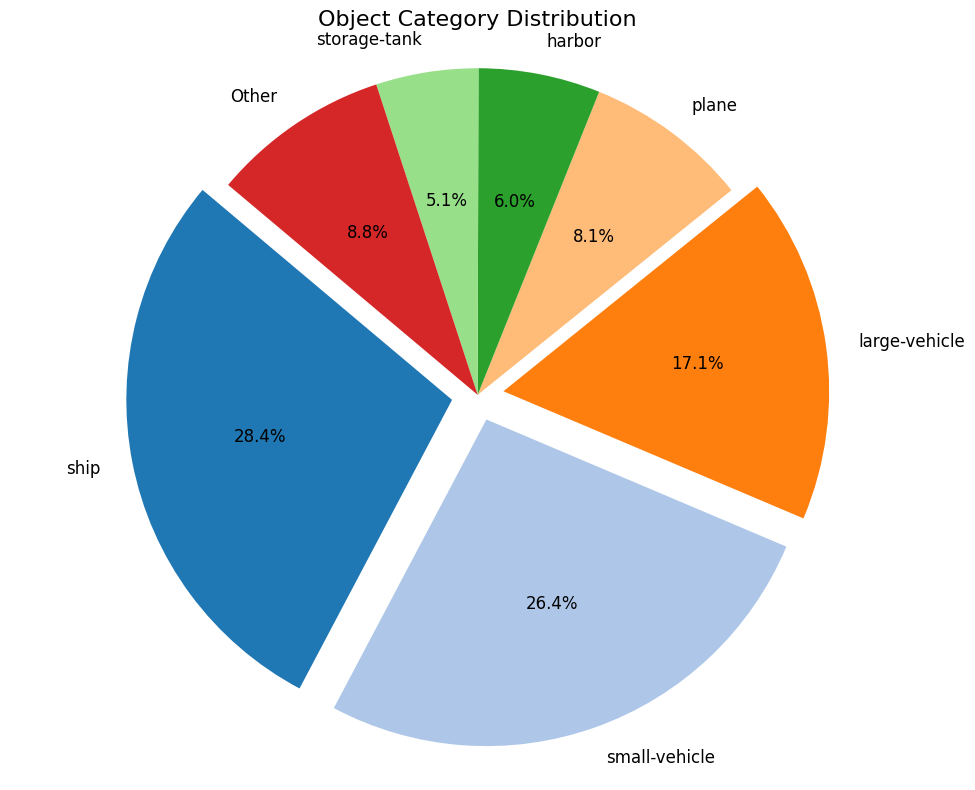

In [6]:
# Parameters
top_n = 6  # how many categories to show individually
colors = plt.cm.tab20.colors  # colorful palette

# Group small categories as 'Other'
df_counts_top = df_counts.head(top_n).copy()
other = df_counts.iloc[top_n:]["Count"].sum()
df_counts_top.loc[len(df_counts_top)] = ["Other", other]

# Create labels and data
labels = df_counts_top["Category"]
sizes = df_counts_top["Count"]

# Explode top 3 slightly
explode = [0.08 if i < 3 else 0 for i in range(len(sizes))]

# Plot
plt.figure(figsize=(10, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    explode=explode,
    colors=colors[:len(sizes)],
    textprops={'fontsize': 12}
)
plt.title("Object Category Distribution", fontsize=16)
plt.axis("equal")
plt.tight_layout()
plt.show()

## 2.2 Percentage of Difficult Annotations Per Category

In [7]:
# Initialize counters
category_total = defaultdict(int)
category_difficult = defaultdict(int)

# Parse the zip
with ZipFile(zip_path, 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.txt'):
            with zip_file.open(file_name) as file:
                for line in file:
                    try:
                        parts = line.decode('utf-8').strip().split()
                        if len(parts) >= 10:
                            category = parts[8].strip()
                            difficult = parts[-1].strip()
                            category_total[category] += 1
                            if difficult == '1':
                                category_difficult[category] += 1
                    except Exception as e:
                        print(f"[ERROR] {file_name}: {e}")

In [8]:
# Combine into DataFrame
df_difficulty = pd.DataFrame({
    'Category': category_total.keys(),
    'Total': [category_total[c] for c in category_total],
    'Difficult': [category_difficult.get(c, 0) for c in category_total]
})

# Add % column
df_difficulty['Difficult %'] = (df_difficulty['Difficult'] / df_difficulty['Total']) * 100

# Sort by descending % of difficulty
df_difficulty = df_difficulty.sort_values(by='Difficult %', ascending=False)
df_difficulty.reset_index(drop=True, inplace=True)
df_difficulty.head()

,Category,Total,Difficult,Difficult %
0,soccer-ball-field,326,120,36.809816
1,storage-tank,5029,1005,19.984092
2,ground-track-field,325,36,11.076923
3,small-vehicle,26126,2646,10.127842
4,basketball-court,515,52,10.097087


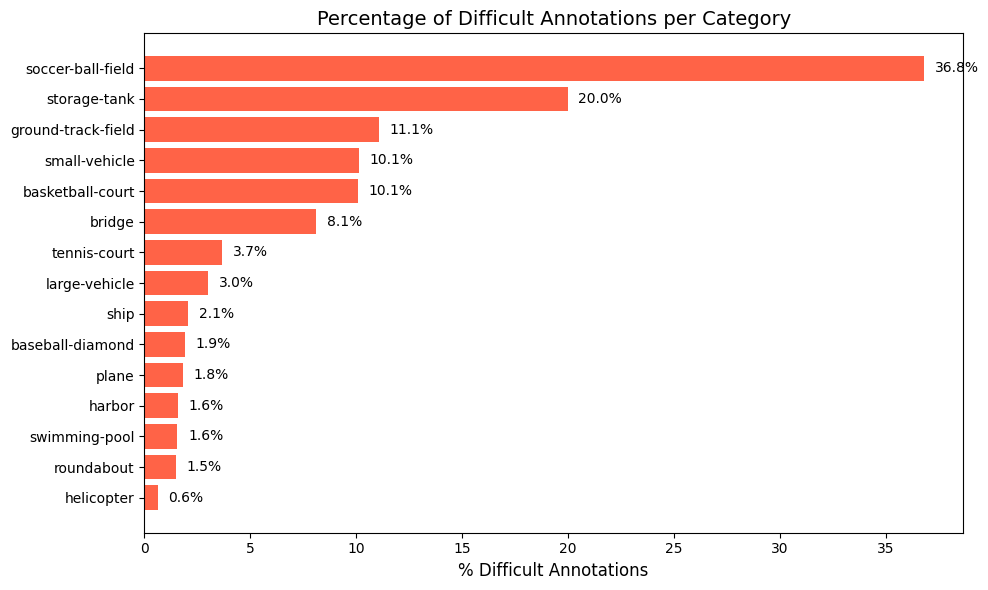

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df_difficulty['Category'], df_difficulty['Difficult %'], color='tomato')
plt.xlabel('% Difficult Annotations', fontsize=12)
plt.title('Percentage of Difficult Annotations per Category', fontsize=14)

# Add text labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
             f'{width:.1f}%', va='center', fontsize=10)

plt.gca().invert_yaxis()  # highest % on top
plt.tight_layout()
plt.show()

## 2.3 Object Bounding Box Sizes Per Category

In [10]:
# Shoelace formula for quadrilateral area
def polygon_area(x, y):
    return 0.5 * abs(sum(x[i] * y[(i + 1) % 4] - x[(i + 1) % 4] * y[i] for i in range(4)))


# Collect areas per category
category_areas = defaultdict(list)

with ZipFile(zip_path, 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.txt'):
            with zip_file.open(file_name) as file:
                for line in file:
                    try:
                        parts = line.decode('utf-8').strip().split()
                        if len(parts) >= 10:
                            x_coords = list(map(float, parts[0:8:2]))  # x1, x2, x3, x4
                            y_coords = list(map(float, parts[1:8:2]))  # y1, y2, y3, y4
                            area = polygon_area(x_coords, y_coords)
                            category = parts[8].strip()
                            category_areas[category].append(area)
                    except Exception as e:
                        print(f"[ERROR] {file_name}: {e}")

In [11]:
# Flatten into long-form DataFrame
records = []
for category, areas in category_areas.items():
    for area in areas:
        records.append({'Category': category, 'Area': area})

df_area = pd.DataFrame(records)

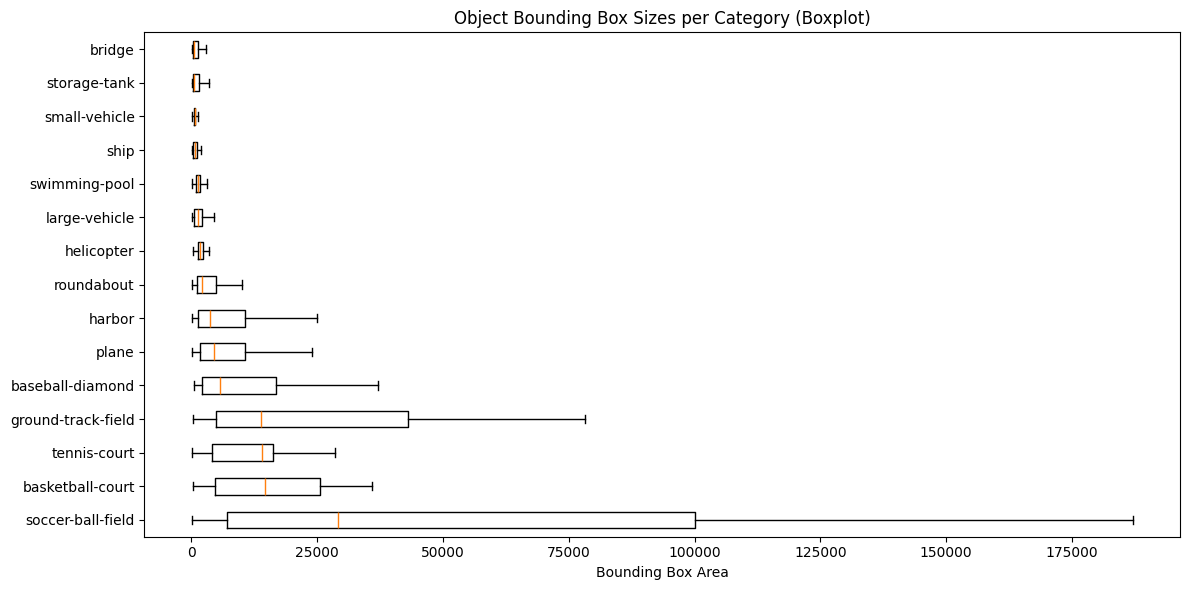

In [12]:
# Plotting
plt.figure(figsize=(12, 6))
sorted_categories = df_area.groupby("Category")["Area"].median().sort_values(ascending=False).index
df_area_sorted = df_area.copy()
df_area_sorted["Category"] = pd.Categorical(df_area_sorted["Category"], categories=sorted_categories)

plt.boxplot(
    [df_area_sorted[df_area_sorted["Category"] == cat]["Area"] for cat in sorted_categories],
    tick_labels=sorted_categories,
    showfliers=False,
    vert=False
)

# Add text labels to bars
plt.xlabel("Bounding Box Area")
plt.title("Object Bounding Box Sizes per Category (Boxplot)")
plt.tight_layout()
plt.show()

# 4 Modelling

## 4.1 You Only Look Once Model (YOLO V1)

### 4.1.1 Define Dataset Class and Load the Data

In [13]:
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, img_size=448):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        img_path = os.path.join(self.image_dir, fname)
        label_path = os.path.join(self.label_dir, fname.replace(".png", ".txt"))

        # Load image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

        # Load label
        targets = []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, x, y, w, h = map(float, parts)
                        targets.append([cls, x, y, w, h])

        targets = torch.tensor(targets, dtype=torch.float32)
        return img, targets

# Load the Data
image_dir = os.path.join(DATASET_ROOT_DIR, 'train/images')
label_dir = os.path.join(DATASET_ROOT_DIR, 'train/labelTxt')
## Use 1/3 data to train model
#image_dir = "/content/drive/MyDrive/images"
#label_dir = "/content/drive/MyDrive/labelTxt"

dataset = YoloDataset(image_dir, label_dir)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Test loading
for imgs, labels in loader:
    print("Image batch shape:", imgs.shape)
    print("Labels shape:", labels.shape)
    break

Image batch shape: torch.Size([2, 3, 448, 448])
Labels shape: torch.Size([2, 0])


In [14]:
class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=15):
        super(YOLOv1, self).__init__()
        self.S = S
        self.B = B
        self.C = C

        def conv_block(in_c, out_c, pool=True):
            layers = [
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            ]
            if pool:
                layers.append(nn.MaxPool2d(2))
            return nn.Sequential(*layers)

        self.feature_extractor = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512, pool=False),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, S * S * (C + B * 5))
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.head(x)
        return x.view(-1, self.S, self.S, self.C + self.B * 5)

In [15]:
class YOLOLoss(nn.Module):
    def __init__(self, S=7, B=2, C=15, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, predictions, target):
        N = predictions.size(0)
        predictions = predictions.view(N, self.S, self.S, self.C + self.B * 5)
        target = target.view(N, self.S, self.S, self.C + self.B * 5)

        # Get mask for object cells
        obj_mask = target[..., self.C] > 0

        # No-object mask
        noobj_mask = target[..., self.C] == 0

        # ===================== #
        #   Coordinate Loss
        # ===================== #
        box_pred = predictions[..., self.C+1:self.C+5][obj_mask]
        box_target = target[..., self.C+1:self.C+5][obj_mask]

        coord_loss = self.mse(box_pred, box_target)

        # ===================== #
        #   Objectness Loss
        # ===================== #
        conf_pred = predictions[..., self.C][obj_mask]
        conf_target = target[..., self.C][obj_mask]
        obj_loss = self.mse(conf_pred, conf_target)

        # ===================== #
        #   No-object Loss
        # ===================== #
        noobj_pred = predictions[..., self.C][noobj_mask]
        noobj_target = target[..., self.C][noobj_mask]
        noobj_loss = self.mse(noobj_pred, noobj_target)

        # ===================== #
        #   Class Loss
        # ===================== #
        class_pred = predictions[..., :self.C][obj_mask]
        class_target = target[..., :self.C][obj_mask]
        class_loss = self.mse(class_pred, class_target)

        total_loss = (
            self.lambda_coord * coord_loss +
            obj_loss +
            self.lambda_noobj * noobj_loss +
            class_loss
        )

        return total_loss / N

### 4.1.2 YOLO Target Encoder

In [16]:
def encode_targets(targets, S=7, B=2, C=15):
    """
    Convert list of boxes [class, x, y, w, h] into a YOLOv1-style tensor.
    Output shape: [S, S, C + B*5]
    """
    target_tensor = torch.zeros((S, S, C + B * 5))

    for obj in targets:
        cls, x, y, w, h = obj
        i = int(x * S)
        j = int(y * S)

        if i >= S: i = S - 1
        if j >= S: j = S - 1

        x_cell = x * S - i
        y_cell = y * S - j

        if target_tensor[j, i, C] == 0:
            target_tensor[j, i, C] = 1  # object confidence
            target_tensor[j, i, C+1:C+5] = torch.tensor([x_cell, y_cell, w, h])
            target_tensor[j, i, int(cls)] = 1  # one-hot class

    return target_tensor

### 4.1.3 Model Training and Evaluation

In [17]:
def train_model(model, loader, optimizer, criterion, epochs=5, device='cuda'):
    model.to(device)
    history = []
    for epoch in range(epochs):
        start = time.time()
        model.train()
        total_loss = 0

        for imgs, targets in loader:
            imgs = imgs.to(device)
            labels = [encode_targets(t, C=15) for t in targets]
            labels = torch.stack(labels).to(device)

            preds = model(imgs)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        duration = time.time() - start
        loss_avg = total_loss / len(loader)
        history.append(loss_avg)

        print(f"Epoch {epoch+1}/{epochs} - {duration:.0f}s "
              f"{len(loader)} batches - loss: {loss_avg:.4f}")

    return history

In [ ]:
model = YOLOv1()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = YOLOLoss(S=7, B=2, C=15)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

history = train_model(model, train_loader, optimizer, criterion, epochs=10, device=device)

Epoch 1/10 - 146s 235 batches - loss: 1.0466


## 4.2 You Only Look Once Model (YOLO V11)

### 4.2.1 Summary of YOLO V11

In [3]:
# YOLOV11 model
yolo11 = modeling_yolo11.load_model(init=True)
yolo11

load model from ../models/yolo11/yolo11n-obb-latest.pt, config: yolo11n-obb.yaml


YOLO(
  (model): OBBModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=

### 4.2.2 Model Training and Evaluation

In [ ]:
yolo11_train_results = modeling_yolo11.train_model(yolo11, epochs=1)

In [ ]:
yolo11_val_results = modeling_yolo11.val_model(yolo11)

## 4.3 Faster Region-based Convolutional Neural Network (Faster RCNN)

### 4.3.1 Summary of Faster RCNN

Faster R-CNN is an advanced object detection model based on region proposal algorithms( S. Ren, 2017). It introduced a Region Proposal Network (RPN), which enhances full-image convolutional features for better performance. The RPN is trained to provide regional proposals. The base model used in this project was trained to fit on PASCAL VOC and MS COCO datasets.

Although the model performs well on the COCO dataset, some tuning is still required when migrating to the DOTA dataset. This includes changing the number of output types to 15 and retraining the output layer. In addition, the change of dataset also requires re-fine-tuning the parameters of all layers. Additionally, models based on low resolution images (COCO) are not suitable for prediction on high resolution images (DOTA). To address this issue,  we cut the image into n\*n image tiles for prediction, and then merge the prediction results into the final output. After some attempts, we found that the model performed better for 5*5 tiles.

In [5]:
# Faster-RCNN model
faster_rcnn = modeling_faster_rcnn.load_model(
    model_name='fasterrcnn/fasterrcnn_s5_e12.pth',
    root=MODEL_ROOT_DIR,
)
faster_rcnn

load from local model: ../models\fasterrcnn/fasterrcnn_s5_e12.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### 4.3.2 Model Training and Evaluation

To train the Faster R-CNN model, a training dataset loader and a validating dataset loader were created and passed to the customized training function for automatically train and validate. Due to the limitation of computing and storage resources, only several images were uploaded to GitHub. For fully training, please download the whole DOTA dataset and unzip the files to the training and validation folders respectively, and then run the modeling_faster_rcnn.py script.

In [8]:
# Number of separating per edge
version = 13
# Data Loader for Faster-RCNN
faster_rcnn_train_loader = data_loader.faster_rcnn_data_loader(
    image_dir=os.path.join(DATASET_ROOT_DIR, 'train/images'),
    label_dir=os.path.join(DATASET_ROOT_DIR, 'train/labelTxt'),
    batch_size=2,
    num_workers=2,
)
faster_rcnn_val_loader = data_loader.faster_rcnn_data_loader(
    image_dir=os.path.join(DATASET_ROOT_DIR, 'val/images'),
    label_dir=os.path.join(DATASET_ROOT_DIR, 'val/labelTxt'),
    batch_size=2,
    num_workers=2,
)
# Train Faster-RCNN model
history = modeling_faster_rcnn.train_model(
    faster_rcnn,
    train_data_loader=faster_rcnn_train_loader,
    val_data_loader=faster_rcnn_val_loader,
    lr = 0.05, momentum = 0.5, weight_decay = 0.0001, step_size = 8, gamma = 0.1,
    epochs=1,
)
f'train: {history[0][0]}, val: {history[0][1]}'

training faster-rcnn model
processed 6 images.
validate model
processed 5 images.Epoch 1 Loss: 1.0321150024731953, avg_val_loss: 0.8337863385677338


'train: 1.0321150024731953, val: 0.8337863385677338'

In [9]:
# Save Faster-RCNN model
modeling_faster_rcnn.save_model(
    faster_rcnn,
    model_name=f'fasterrcnn/fasterrcnn_s5_v{version}.pth',
    model_path=MODEL_ROOT_DIR,
)

saved model to ../models\fasterrcnn/fasterrcnn_s5_v13.pth


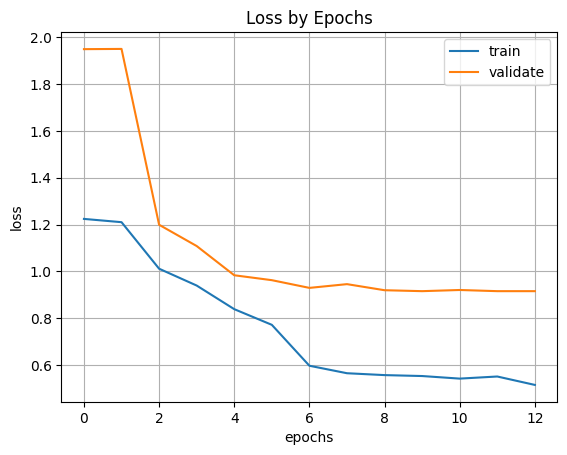

In [12]:
modeling_faster_rcnn.show_history()

### 4.3.3 Results and Discussion

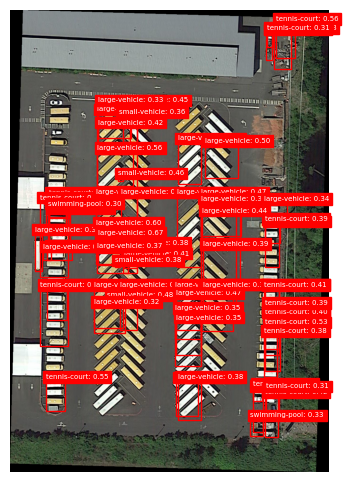

In [6]:
test_img_path = os.path.join(DATASET_ROOT_DIR, 'test/images/P0006.png')
# Predict and Visualize the results
fasterrcnn_results = modeling_faster_rcnn.predict(
    faster_rcnn,
    image_path=test_img_path,
    confidence_threshold=0.3,
)
modeling_faster_rcnn.show_results(
    image_path=test_img_path,
    prediction=fasterrcnn_results,
    show_label=True,
)

# 5 Evaluation
## 5.1 Performance Measures

THE DOTA dataset is pre-divided into training, validation, and test subsets.

All models were trained on the training set. For evaluation purposes, only the validation and test sets were used.

Evaluation Metrics, mAP (mean Average Precision) is used to evaluate the performance of both YOLO v11 and Faster R-CNN models. 
YOLOv11 is implemented within the Ultralytics framework, which provides val() method capable of performing mAP computation
and a range of other evaluation tasks directly within the model.

The following code is designed for evaluating Faster R-CNN model

In [ ]:
# evaluation needs new models
# faster_rcnn = modeling_faster_rcnn.load_model(
#     init=False,
#     root=MODEL_ROOT_DIR,
#     model_name='fasterrcnn/fasterrcnn_s5_e4.pth',
# )

val_results = modeling_faster_rcnn.validate_model(
    faster_rcnn,
    img_dir=os.path.join(DATASET_ROOT_DIR, 'val/images'),
    val_output=os.path.join(DATASET_ROOT_DIR, 'val/fasterrcnn_prediction'),
    confidence_threshold=0.3,
    separate=5,
)

In [25]:
data_validation.run_dota_evaluation(DATASET_ROOT_DIR,printclassap=False)

Mean AP: 0.0037


$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{Method} & \textbf{mAP@0.5} & \textbf{Plane} & \textbf{BD} & \textbf{Bridge} & \textbf{GTF} & \textbf{SV} & \textbf{LV} & \textbf{Ship} & \textbf{TC} & \textbf{BC} & \textbf{ST} & \textbf{SBF} & \textbf{RA} & \textbf{Harbor} & \textbf{SP} & \textbf{HC}  \\
\hline
Faster RCNN  & 0.79 & 0.02  & 0.02 & 0.01 & 0.01 & 0.33 & 2.27 & 1.02 & 0.00 & 3.92 & 3.92  & 0.03 & 0.02 & 0.00 & 0.29 & 0.01 \\
YOLO v11n  & 57.4 & 89.2 & 63.8 & 39.2 & 36.1 & 55.4 & 74.4 & 81.7 & 82.8 & 36.9 & 64.8 & 37.6 & 63.5 & 69.7 & 52.1 & 13.6 \\
\hline
\end{array}
$$

## 5.2 Comparison of Color Channels

In [27]:
#  Using test images
#  set file path, can modified if appropriate
image_filename = 'P0035.png'
enhanced_dir = 'evaluation/RGBHance/'
yolo_save_dir = 'evaluation/YOLO predict/'
faster_rcnn_dir = 'evaluation/RCNN predict/'
os.makedirs(yolo_save_dir, exist_ok=True)
os.makedirs(faster_rcnn_dir, exist_ok=True)

image_paths = data_validation.enhance_and_save_images(image_filename, DATASET_ROOT_DIR, enhanced_dir)

for path in image_paths:
    # YOLO
    results = yolo11(path)
    output_path = os.path.join(yolo_save_dir, os.path.basename(path))
    results[0].save(output_path)
    # Faster R-CNN
    faster_rcnn_predictimage = modeling_faster_rcnn.predict(
        faster_rcnn,
        image_path=path,
        confidence_threshold=0.3,
        separate=4,
    )
    modeling_faster_rcnn.show_results(
        image_path=path,
        prediction=faster_rcnn_predictimage,
        show_label=False,
        saved_img_path=os.path.join(faster_rcnn_dir, os.path.basename(path)),
    )

print("Images have been processed and saved.")


image 1/1 D:\git\VisualDota\src\data\test\images\P0035.png: 608x768 None127.0ms
Speed: 17.7ms preprocess, 127.0ms inference, 296.7ms postprocess per image at shape (1, 3, 608, 768)

image 1/1 D:\git\VisualDota\src\evaluation\RGBHance\P0035_red_enhanced.png: 608x768 None76.3ms
Speed: 6.6ms preprocess, 76.3ms inference, 9.3ms postprocess per image at shape (1, 3, 608, 768)

image 1/1 D:\git\VisualDota\src\evaluation\RGBHance\P0035_green_enhanced.png: 608x768 None44.0ms
Speed: 5.0ms preprocess, 44.0ms inference, 7.2ms postprocess per image at shape (1, 3, 608, 768)

image 1/1 D:\git\VisualDota\src\evaluation\RGBHance\P0035_blue_enhanced.png: 608x768 None41.6ms
Speed: 5.0ms preprocess, 41.6ms inference, 5.4ms postprocess per image at shape (1, 3, 608, 768)

image 1/1 D:\git\VisualDota\src\evaluation\RGBHance\P0035_red_reduced.png: 608x768 None43.1ms
Speed: 4.7ms preprocess, 43.1ms inference, 5.8ms postprocess per image at shape (1, 3, 608, 768)

image 1/1 D:\git\VisualDota\src\evaluation\

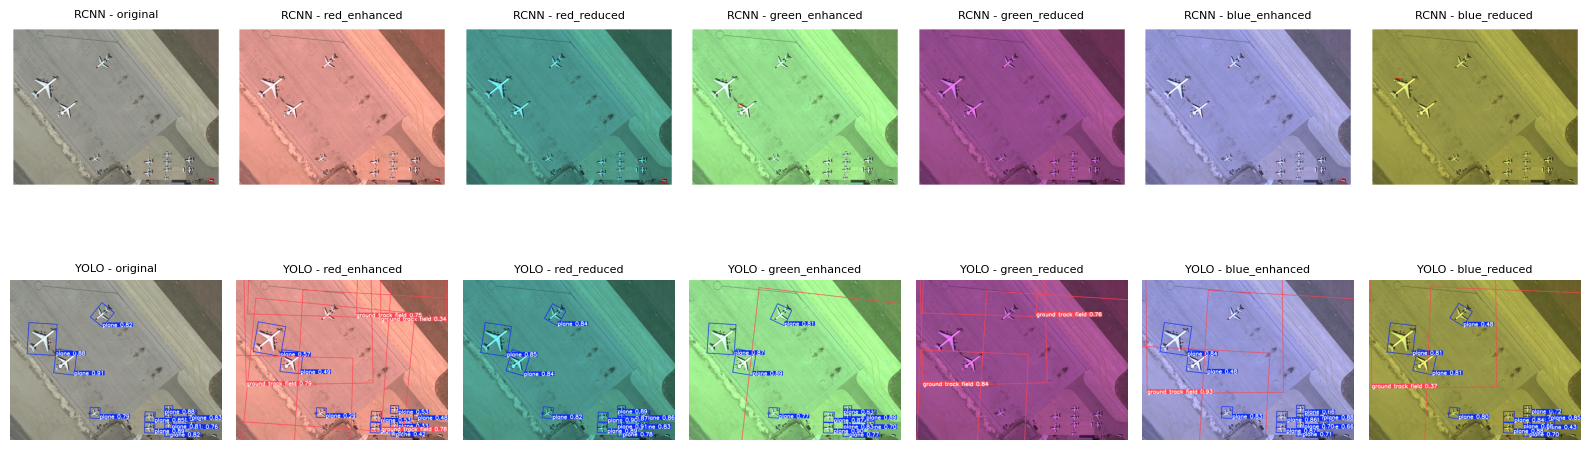

In [28]:
# target Image
image_filename = 'P0035.png'
data_validation.display_images(image_filename, yolo_save_dir, faster_rcnn_dir)

# Summary